In [17]:
import pandas as pd 
import numpy as np
from sklearn import ensemble
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    accuracy_score,
    balanced_accuracy_score,
    roc_auc_score,
    f1_score,
    r2_score,
    mean_squared_error,
)

In [18]:
import warnings
warnings.filterwarnings('ignore')

In [19]:
df = pd.read_csv('dataset/UNSW_NB15_training-set.csv') 
X = df.drop(['label','attack_cat','id'], axis=1)
y= df['label']

In [20]:
numeric_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="mean")), ("scaler", StandardScaler())]
)

categorical_transformer_low = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="constant", fill_value="missing")),
        ("encoding", OneHotEncoder(handle_unknown="ignore", sparse=False)),
    ]
)

categorical_transformer_high = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="constant", fill_value="missing")),
        # 'OrdianlEncoder' Raise a ValueError when encounters an unknown value. Check https://github.com/scikit-learn/scikit-learn/pull/13423
        ("encoding", OrdinalEncoder()),
    ]
)

def get_card_split(df, cols, n=11):
    """
    Splits categorical columns into 2 lists based on cardinality (i.e # of unique values)
    Parameters
    ----------
    df : Pandas DataFrame
        DataFrame from which the cardinality of the columns is calculated.
    cols : list-like
        Categorical columns to list
    n : int, optional (default=11)
        The value of 'n' will be used to split columns.
    Returns
    -------
    card_low : list-like
        Columns with cardinality < n
    card_high : list-like
        Columns with cardinality >= n
    """
    cond = df[cols].nunique() > n
    card_high = cols[cond]
    card_low = cols[~cond]
    return card_low, card_high


In [21]:
def transformData(X):
    numeric_features = X.select_dtypes(include=[np.number]).columns
    categorical_features = X.select_dtypes(include=["object"]).columns

    categorical_low, categorical_high = get_card_split(
        X, categorical_features
    )

    ct = ColumnTransformer(
        transformers=[
            ("numeric", numeric_transformer, numeric_features),
            ("categorical_low", categorical_transformer_low, categorical_low),
            ("categorical_high", categorical_transformer_high, categorical_high),
        ]
    ) 

    return ct.fit_transform(X)

In [22]:
features_in_order = ['ct_dst_src_ltm', 'ct_srv_dst', 'sbytes', 'ct_srv_src', 'service', 'ct_src_ltm', 'sttl', 'ct_dst_ltm', 'dbytes', 'ackdat', 'dttl', 'sinpkt', 'smean', 'response_body_len', 'rate', 'sjit', 'tcprtt', 'ct_flw_http_mthd', 'swin',
                     'is_sm_ips_ports', 'dinpkt', 'proto', 'dur', 'dpkts', 'ct_dst_sport_ltm', 'sloss', 'ct_ftp_cmd', 'spkts', 'state', 'dwin', 'dmean', 'djit', 'ct_src_dport_ltm', 'trans_depth', 'synack', 'is_ftp_login', 'ct_state_ttl', 'dloss', 'dload', 'sload', 'dtcpb', 'stcpb']


In [23]:
df

,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
0,1,0.000011,udp,-,INT,2,0,496,0,90909.090200,...,1,2,0,0,0,1,2,0,Normal,0
1,2,0.000008,udp,-,INT,2,0,1762,0,125000.000300,...,1,2,0,0,0,1,2,0,Normal,0
2,3,0.000005,udp,-,INT,2,0,1068,0,200000.005100,...,1,3,0,0,0,1,3,0,Normal,0
3,4,0.000006,udp,-,INT,2,0,900,0,166666.660800,...,1,3,0,0,0,2,3,0,Normal,0
4,5,0.000010,udp,-,INT,2,0,2126,0,100000.002500,...,1,3,0,0,0,2,3,0,Normal,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82327,82328,0.000005,udp,-,INT,2,0,104,0,200000.005100,...,1,2,0,0,0,2,1,0,Normal,0
82328,82329,1.106101,tcp,-,FIN,20,8,18062,354,24.410067,...,1,1,0,0,0,3,2,0,Normal,0
82329,82330,0.000000,arp,-,INT,1,0,46,0,0.000000,...,1,1,0,0,0,1,1,1,Normal,0
82330,82331,0.000000,arp,-,INT,1,0,46,0,0.000000,...,1,1,0,0,0,1,1,1,Normal,0


In [24]:
X_trans = transformData(X) 

In [25]:
acc_list = [0.00]
auc_list = [0.00]
f1s_list = [0.00]

num_folds = 10 
# num_features = 1 
for num_features in range(1,len(features_in_order)):
    acc = 0
    auc = 0
    f1s = 0
    # print(num_features)
    X[features_in_order[0:num_features]]
    X_i_features = transformData(X[features_in_order[0:num_features]] ) 

    for i in range(num_folds): 
        X_train, X_test, y_train, y_test = train_test_split(X_i_features, y,test_size=.1, random_state=(314*i)) 
        clf = ensemble.RandomForestClassifier()
        clf = clf.fit(X_train, y_train) 
        y_pred = clf.predict(X_train)
        acc += accuracy_score(y_train, y_pred, normalize=True)
        auc += roc_auc_score(y_train, clf.predict_proba(X_train)[:, 1])
        f1s += f1_score(y_train, y_pred)
    
    folded_acc = acc/num_folds
    folded_auc = auc/num_folds
    folded_f1s = f1s/num_folds
    acc_list.append(folded_acc)
    auc_list.append(folded_auc)
    f1s_list.append(folded_f1s)
    # print(folded_acc)


In [26]:
acc_list[10]

0.9989770304191745

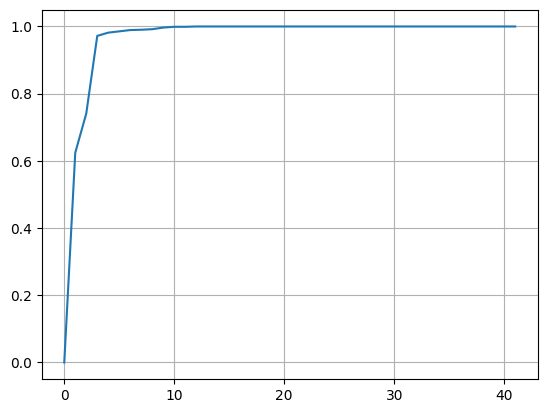

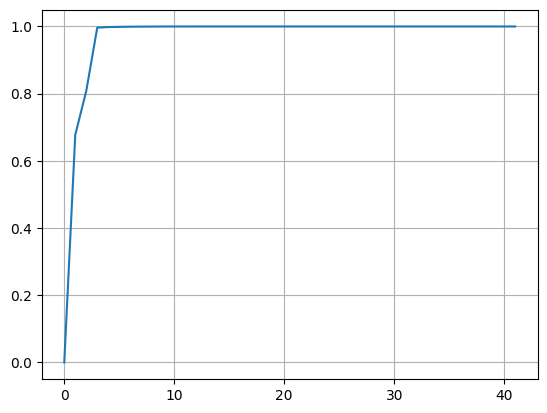

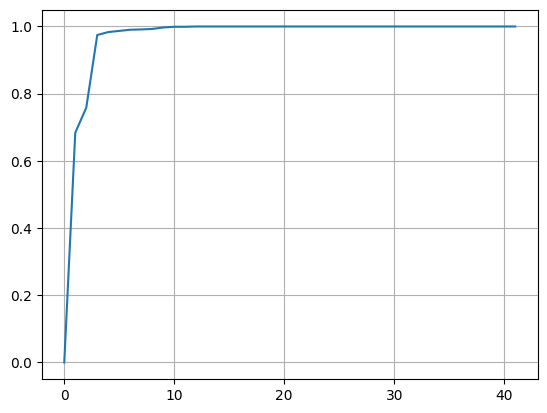

In [27]:
import seaborn as sns 
import matplotlib.pyplot as plt
x_series = list(range(len(acc_list))) 
sns.lineplot(x=x_series, y=acc_list)
plt.grid()  #just add this
plt.show()

x_series = list(range(len(auc_list)))
sns.lineplot(x=x_series, y=auc_list)
plt.grid()
plt.show()

x_series = list(range(len(f1s_list)))
sns.lineplot(x=x_series, y=f1s_list)
plt.grid()
plt.show()

In [28]:
df_valid = pd.read_csv('dataset/UNSW_NB15_testing-set.csv') 
X_valid = df_valid.drop(['label','attack_cat','id'], axis=1)
y_valid= df_valid['label']

In [29]:
acc_list_valid = [0.00]
num_folds = 10 

acc = 0
auc = 0
f1s = 0;

X_i_features_valid = transformData(X_valid[features_in_order[0:10]] ) 

for i in range(num_folds): 
    X_train, X_test, y_train, y_test = train_test_split(X_i_features_valid, y_valid,test_size=.1, random_state=(314*i)) 
    clf = ensemble.RandomForestClassifier()
    clf = clf.fit(X_train, y_train) 
    y_pred = clf.predict(X_test)
    acc += accuracy_score(y_test, y_pred, normalize=True)
    auc += roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])
    f1s += f1_score(y_test, y_pred)
    
folded_acc = acc/num_folds
folded_auc = auc/num_folds
folded_f1s = f1s/num_folds
acc_list_valid.append({'Folded Accuracy': folded_acc, 'Folded ROC': folded_auc, 'Folded F1 Score': folded_f1s})

In [30]:
acc_list_valid

[0.0,
 {'Folded Accuracy': 0.9617678927858566,
  'Folded ROC': 0.9935729876173192,
  'Folded F1 Score': 0.9721004151668478}]